# Loading the BCCD dataset

In [ ]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
import torch
from torch.utils.data import Dataset

class BCCDDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # Load all image files, sorting them to ensure alignment with annotations
        self.imgs = list(sorted(os.listdir(os.path.join(root, "JPEGImages"))))
        self.annotations = list(sorted(os.listdir(os.path.join(root, "Annotations"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "JPEGImages", self.imgs[idx])
        ann_path = os.path.join(self.root, "Annotations", self.annotations[idx])
        img = Image.open(img_path).convert("RGB")

        # Parse XML (Pascal VOC format)
        tree = ET.parse(ann_path)
        root = tree.getroot()
        boxes = []
        labels = []

        for obj in root.findall('object'):
            bndbox = obj.find('bndbox')
            xmin = float(bndbox.find('xmin').text)
            ymin = float(bndbox.find('ymin').text)
            xmax = float(bndbox.find('xmax').text)
            ymax = float(bndbox.find('ymax').text)

            # --- Validation Check ---
            # PyTorch models require xmax > xmin and ymax > ymin to calculate loss.
            if xmax > xmin and ymax > ymin:
                label = obj.find('name').text
                # Map labels to integers (Example: RBC=1, WBC=2, Platelets=3)
                label_map = {"RBC": 1, "WBC": 2, "Platelets": 3}
                labels.append(label_map[label])
                boxes.append([xmin, ymin, xmax, ymax])
            else:
                # Log the issue so you know which file has a "dot" annotation
                print(f"Warning: Skipping invalid box {xmin, ymin, xmax, ymax} in {self.annotations[idx]}")

        # Safety net: If an image has NO valid boxes, move to the next image
        if len(boxes) == 0:
            return self.__getitem__((idx + 1) % len(self.imgs))

        target = {
            "boxes": torch.as_tensor(boxes, dtype=torch.float32),
            "labels": torch.as_tensor(labels, dtype=torch.int64),
            "image_id": torch.tensor([idx])
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

#Initialising the hyperparameters

In [ ]:
import torch
#/content/BCCD_Dataset-master
# Dataset Paths
DATA_ROOT = "/content/BCCD_Dataset-master/BCCD"
MODEL_SAVE_PATH = "model_weights.pth"

# Hyperparameters
NUM_CLASSES = 4  # 3 classes (RBC, WBC, Platelets) + 1 Background
BATCH_SIZE = 4
LR = 0.005
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005
NUM_EPOCHS = 10

# Environment
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#Initialising the baseline and stronger models

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn, fasterrcnn_mobilenet_v3_large_fpn

def get_model(num_classes):
    # Load a stronger model pre-trained on COCO (R-CNN ResNet50 FPN)
    #model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    #baseline-model (uncomment the line below to use the baseline model and comment the model declaration above)
    model = fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)

    # Replace the classifier head for our 3 blood cell classes + background
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Training with the Baseline Model (R-CNN ResNet50 FPN)

In [ ]:
#training with baseline model
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
#from data_loader import BCCDDataset
#from model_factory import get_model
#import config

def get_transform():
    return transforms.Compose([
        transforms.ToTensor(), # Converts PIL Image to Tensor
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

def main():
    # Pass the transform here to fix the AttributeError
    full_dataset = BCCDDataset(root=DATA_ROOT, transforms=get_transform())

    # --- Proper Train/Validation Split [cite: 82] ---
    dataset_size = len(full_dataset)
    indices = torch.randperm(dataset_size).tolist()
    train_split = int(0.8 * dataset_size)

    train_indices = indices[:train_split]
    val_indices = indices[train_split:]

    train_loader = DataLoader(
        Subset(full_dataset, train_indices),
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn
    )

    model = get_model(num_classes=NUM_CLASSES)
    model.to(DEVICE)

    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=LR,
        momentum=MOMENTUM,
        weight_decay=WEIGHT_DECAY
    )

    print(f"Starting training on {DEVICE}...")
    model.train()
    for epoch in range(NUM_EPOCHS):
        epoch_loss = 0
        for images, targets in train_loader:
            # Now images are Tensors and .to() will work
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            epoch_loss += losses.item()

        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {epoch_loss/len(train_loader):.4f}")

    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"Model saved to {MODEL_SAVE_PATH}")

if __name__ == "__main__":
    main()



/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


100%|██████████| 74.2M/74.2M [00:00<00:00, 213MB/s]


Starting training on cuda...
Epoch 1/10 | Loss: 0.9747
Epoch 2/10 | Loss: 0.7031
Epoch 3/10 | Loss: 0.6646
Epoch 4/10 | Loss: 0.6425
Epoch 5/10 | Loss: 0.6217
Epoch 6/10 | Loss: 0.6056
Epoch 7/10 | Loss: 0.5872
Epoch 8/10 | Loss: 0.5809
Epoch 9/10 | Loss: 0.5520
Epoch 10/10 | Loss: 0.5472
Model saved to model_weights.pth


# Training with a stronger model (i.e Faster R-CNN model with a MobileNetV3-Large FPN backbone)

In [ ]:
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import transforms


def get_transform():
    return transforms.Compose([
        transforms.ToTensor(), # Converts PIL Image to Tensor
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

def main():
    # Pass the transform here to fix the AttributeErro r
    full_dataset = BCCDDataset(root=DATA_ROOT, transforms=get_transform())

    # --- Proper Train/Validation Split [cite: 82] ---
    dataset_size = len(full_dataset)
    indices = torch.randperm(dataset_size).tolist()
    train_split = int(0.8 * dataset_size)

    train_indices = indices[:train_split]
    val_indices = indices[train_split:]

    train_loader = DataLoader(
        Subset(full_dataset, train_indices),
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn
    )

    model = get_model(num_classes=NUM_CLASSES)
    model.to(DEVICE)

    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=LR,
        momentum=MOMENTUM,
        weight_decay=WEIGHT_DECAY
    )

    print(f"Starting training on {DEVICE}...")
    model.train()
    for epoch in range(NUM_EPOCHS):
        epoch_loss = 0
        for images, targets in train_loader:
            # Now images are Tensors and .to() will work
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            epoch_loss += losses.item()

        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {epoch_loss/len(train_loader):.4f}")

    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"Model saved to {MODEL_SAVE_PATH}")

if __name__ == "__main__":
    main()



/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 187MB/s]


Starting training on cuda...
Epoch 1/10 | Loss: 0.8413
Epoch 2/10 | Loss: 0.5205
Epoch 3/10 | Loss: 0.4721
Epoch 4/10 | Loss: 0.4579
Epoch 5/10 | Loss: 0.4181
Epoch 6/10 | Loss: 0.3962
Epoch 7/10 | Loss: 0.3816
Epoch 8/10 | Loss: 0.3579
Epoch 9/10 | Loss: 0.3374
Epoch 10/10 | Loss: 0.3133
Model saved to model_weights.pth


# Evaluating with the baseline model

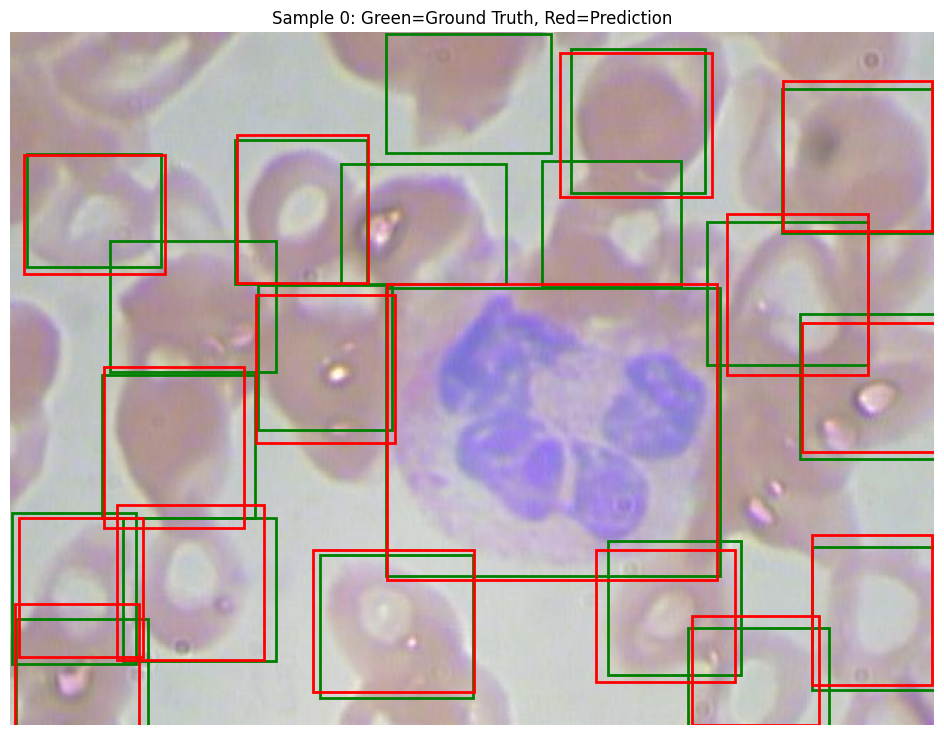

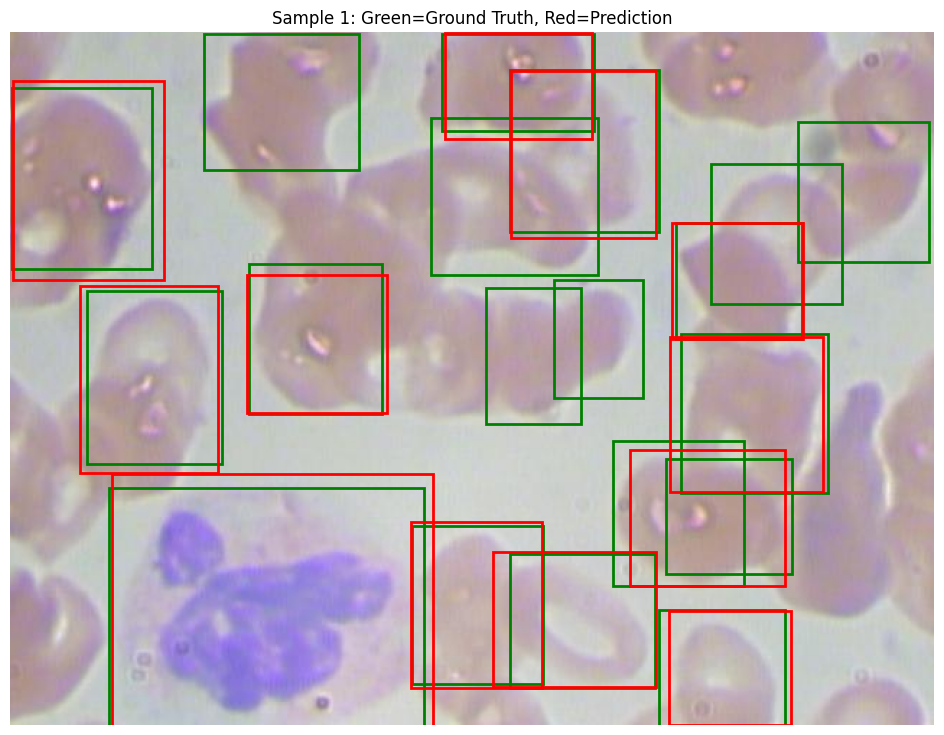

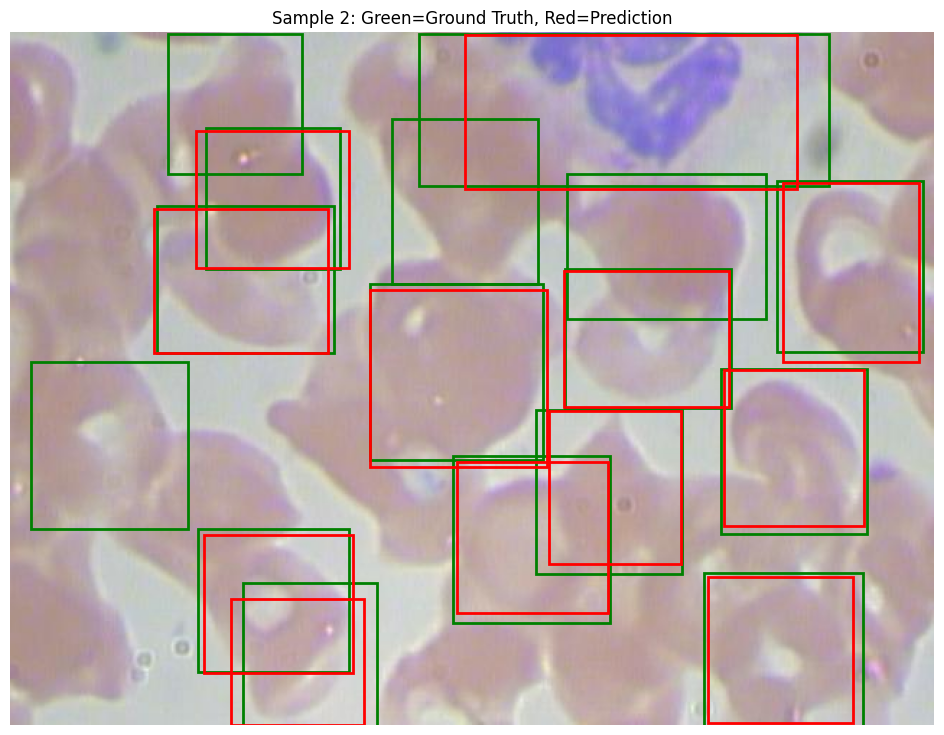

In [ ]:
#evaluating with baseline model
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms


# Define the transform required for Faster R-CNN
def get_transform():
    return transforms.Compose([
        transforms.ToTensor(),
    ])

def visualize_errors(num_samples=3):
    # Pass transforms here to ensure img is a Tensor, not a PIL Image
    dataset = BCCDDataset(root=DATA_ROOT, transforms=get_transform())

    model = get_model(NUM_CLASSES)
    # Load weights into the architecture
    model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()

    for i in range(num_samples):
        img, target = dataset[i]

        # Move image to the correct device
        img_input = img.to(DEVICE)

        with torch.no_grad():
            # Model expects a list of tensors
            prediction = model([img_input])

        # Move back to CPU and change dimensions for plotting (C, H, W) -> (H, W, C)
        plot_img = img.permute(1, 2, 0).cpu().numpy()

        fig, ax = plt.subplots(1, figsize=(12, 9))
        ax.imshow(plot_img)

        # Draw Ground Truth (Green)
        for box in target['boxes']:
            rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                                   linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)

        # Draw Predictions (Red)
        res = prediction[0]
        for box, score in zip(res['boxes'], res['scores']):
            if score > 0.5: # Use confidence threshold
                box = box.cpu().numpy()
                rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                                       linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

        plt.title(f"Sample {i}: Green=Ground Truth, Red=Prediction")
        plt.axis('off')
        plt.show()

if __name__ == "__main__":
    visualize_errors()

# Evaluating with the stronger model

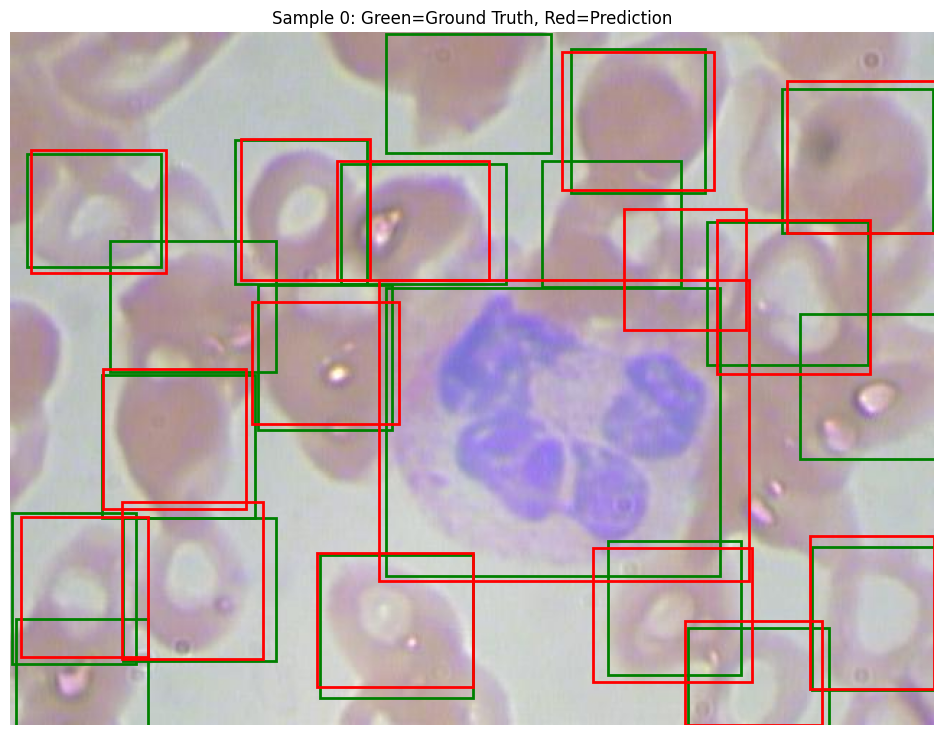

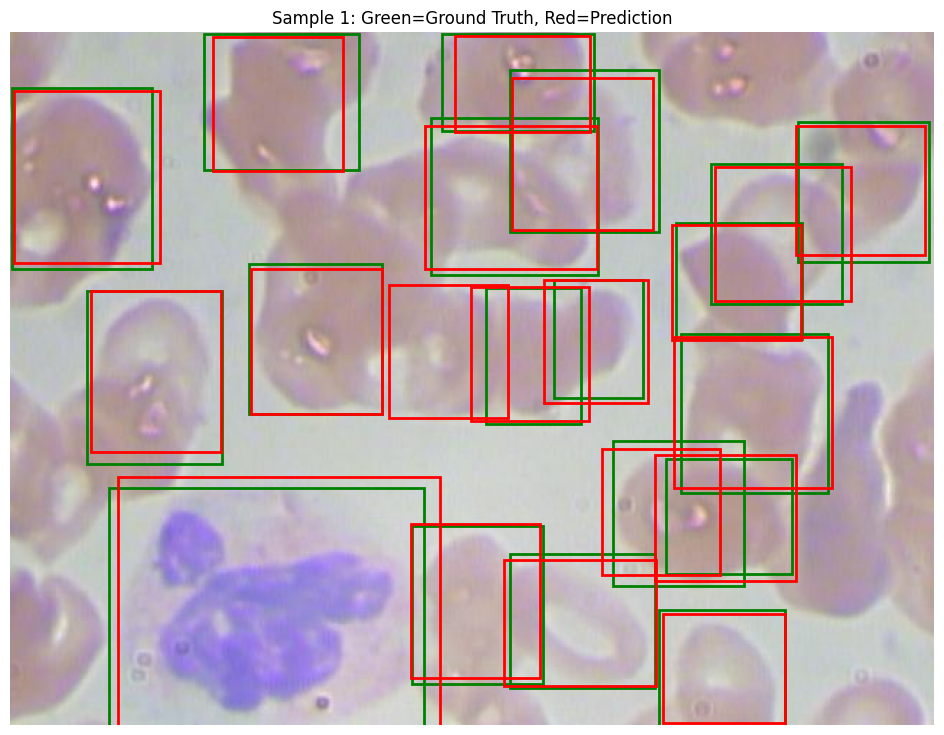

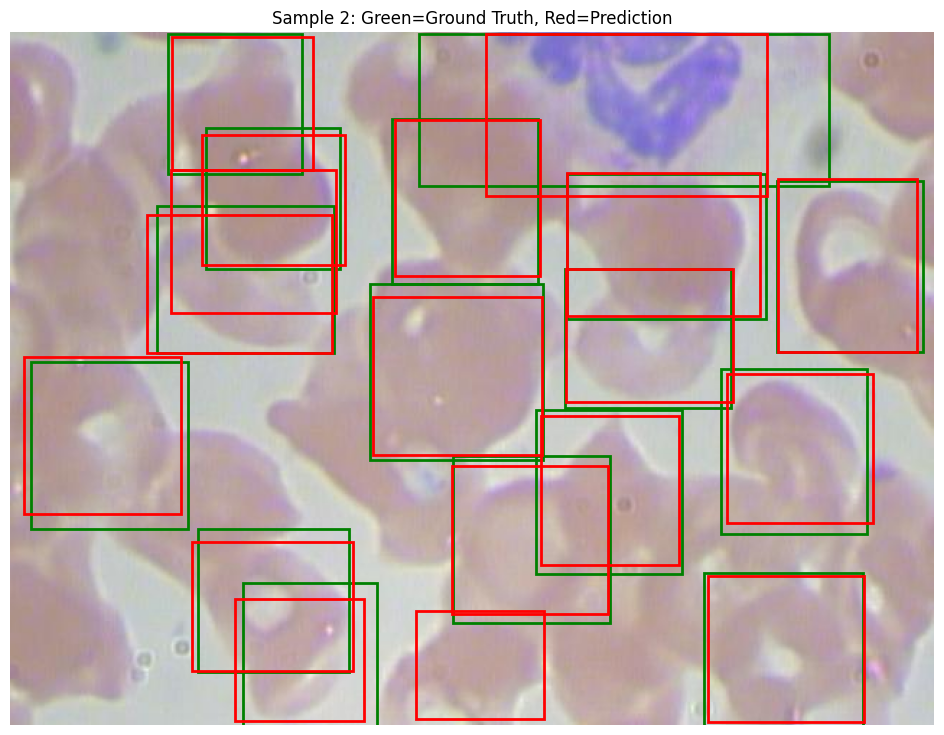

In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms


# Define the transform required for Faster R-CNN
def get_transform():
    return transforms.Compose([
        transforms.ToTensor(),
    ])

def visualize_errors(num_samples=3):
    # Pass transforms here to ensure img is a Tensor, not a PIL Image
    dataset = BCCDDataset(root=DATA_ROOT, transforms=get_transform())

    model = get_model(NUM_CLASSES)
    # Load weights into the architecture
    model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()

    for i in range(num_samples):
        img, target = dataset[i]

        # Move image to the correct device
        img_input = img.to(DEVICE)

        with torch.no_grad():
            # Model expects a list of tensors
            prediction = model([img_input])

        # Move back to CPU and change dimensions for plotting (C, H, W) -> (H, W, C)
        plot_img = img.permute(1, 2, 0).cpu().numpy()

        fig, ax = plt.subplots(1, figsize=(12, 9))
        ax.imshow(plot_img)

        # Draw Ground Truth (Green)
        for box in target['boxes']:
            rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                                   linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)

        # Draw Predictions (Red)
        res = prediction[0]
        for box, score in zip(res['boxes'], res['scores']):
            if score > 0.5: # Use confidence threshold
                box = box.cpu().numpy()
                rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                                       linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

        plt.title(f"Sample {i}: Green=Ground Truth, Red=Prediction")
        plt.axis('off')
        plt.show()

if __name__ == "__main__":
    visualize_errors()